In [1]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
!nvidia-smi

Sun Jun 23 15:19:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P6000                 WDDM  | 00000000:03:00.0  On |                 ERR! |
| 26%   46C    P8              17W / 250W |    225MiB / 24576MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [4]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [5]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [8]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [9]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [11]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [12]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.weight']
Y

device(type='cuda', index=0)

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"], downsampled_labels)
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [14]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-aug-adam-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.FocalLoss(mode="multiclass")
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:25<00:00,  2.21s/it]


Epoch: 1, Loss: 0.208134163735855


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:55<00:00,  1.30s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.053908 | F1-Score: 7.18% | IoU: 4.37% | Precision: 12.22% | Recall: 5.08% | Accuracy: 97.96%
Model saved at 1 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:35<00:00,  2.24s/it]


Epoch: 2, Loss: 0.046448572052101934


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:44<00:00,  1.18s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.035644 | F1-Score: 9.16% | IoU: 5.93% | Precision: 23.00% | Recall: 7.44% | Accuracy: 98.00%
Model saved at 2 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:25<00:00,  2.21s/it]


Epoch: 3, Loss: 0.03409492386685264


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:46<00:00,  1.20s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.029087 | F1-Score: 7.12% | IoU: 4.32% | Precision: 40.27% | Recall: 4.89% | Accuracy: 97.99%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:37<00:00,  2.25s/it]


Epoch: 4, Loss: 0.02972325772768067


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:43<00:00,  1.16s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.026339 | F1-Score: 11.46% | IoU: 7.38% | Precision: 45.73% | Recall: 9.05% | Accuracy: 98.09%
Model saved at 4 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:28<00:00,  2.22s/it]


Epoch: 5, Loss: 0.027319879120876713


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:42<00:00,  1.15s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.024994 | F1-Score: 17.38% | IoU: 10.82% | Precision: 50.67% | Recall: 12.91% | Accuracy: 98.12%
Model saved at 5 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:46<00:00,  2.28s/it]


Epoch: 6, Loss: 0.025962723545249432


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:44<00:00,  1.18s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.023898 | F1-Score: 14.49% | IoU: 8.92% | Precision: 50.67% | Recall: 10.25% | Accuracy: 98.13%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:38<00:00,  2.25s/it]


Epoch: 7, Loss: 0.024879633220693757


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:45<00:00,  1.18s/it]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.023221 | F1-Score: 20.58% | IoU: 12.43% | Precision: 48.80% | Recall: 14.19% | Accuracy: 98.14%
Model saved at 7 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:36<00:00,  2.25s/it]


Epoch: 8, Loss: 0.024137855777817387


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:52<00:00,  1.27s/it]


Validation: Loss: 0.022889 | F1-Score: 25.78% | IoU: 16.01% | Precision: 66.68% | Recall: 19.17% | Accuracy: 98.14%
Model saved at 8 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:43<00:00,  2.27s/it]


Epoch: 9, Loss: 0.02361836777098717


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:45<00:00,  1.19s/it]


Validation: Loss: 0.021815 | F1-Score: 31.67% | IoU: 20.48% | Precision: 61.82% | Recall: 25.51% | Accuracy: 98.23%
Model saved at 9 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:33<00:00,  2.24s/it]


Epoch: 10, Loss: 0.023134019427121646


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:45<00:00,  1.19s/it]


Validation: Loss: 0.021681 | F1-Score: 29.19% | IoU: 18.49% | Precision: 60.92% | Recall: 22.20% | Accuracy: 98.21%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:51<00:00,  2.29s/it]


Epoch: 11, Loss: 0.02278495689313258


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:45<00:00,  1.18s/it]


Validation: Loss: 0.022196 | F1-Score: 30.17% | IoU: 19.09% | Precision: 63.22% | Recall: 23.32% | Accuracy: 98.15%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:14<00:00,  2.17s/it]


Epoch: 12, Loss: 0.022439471863570714


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:24<00:00,  1.06it/s]


Validation: Loss: 0.021158 | F1-Score: 29.26% | IoU: 18.29% | Precision: 66.85% | Recall: 21.33% | Accuracy: 98.24%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:07<00:00,  2.15s/it]


Epoch: 13, Loss: 0.022267277863237164


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.021444 | F1-Score: 32.81% | IoU: 20.75% | Precision: 62.79% | Recall: 25.20% | Accuracy: 98.18%
Model saved at 13 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:11<00:00,  2.17s/it]


Epoch: 14, Loss: 0.021949076886859632


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.020922 | F1-Score: 43.67% | IoU: 28.60% | Precision: 59.41% | Recall: 36.14% | Accuracy: 98.22%
Model saved at 14 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:07<00:00,  2.15s/it]


Epoch: 15, Loss: 0.02167866861507777


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.020496 | F1-Score: 37.10% | IoU: 24.14% | Precision: 62.28% | Recall: 29.89% | Accuracy: 98.28%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:10<00:00,  2.16s/it]


Epoch: 16, Loss: 0.021547680288072555


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:25<00:00,  1.04it/s]


Validation: Loss: 0.021084 | F1-Score: 36.48% | IoU: 23.21% | Precision: 63.09% | Recall: 28.14% | Accuracy: 98.19%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:06<00:00,  2.15s/it]


Epoch: 17, Loss: 0.02137566515575013


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.019892 | F1-Score: 41.50% | IoU: 26.97% | Precision: 64.17% | Recall: 32.61% | Accuracy: 98.31%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:05<00:00,  2.15s/it]


Epoch: 18, Loss: 0.021133354351285005


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:41<00:00,  1.14s/it]


Validation: Loss: 0.019967 | F1-Score: 41.03% | IoU: 26.93% | Precision: 63.46% | Recall: 33.35% | Accuracy: 98.32%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [12:16<00:00,  2.38s/it]


Epoch: 19, Loss: 0.02102761878481796


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:40<00:00,  1.12s/it]


Validation: Loss: 0.020769 | F1-Score: 40.22% | IoU: 25.58% | Precision: 61.54% | Recall: 30.73% | Accuracy: 98.20%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:35<00:00,  2.24s/it]


Epoch: 20, Loss: 0.02091376017478685


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:34<00:00,  1.06s/it]


Validation: Loss: 0.019522 | F1-Score: 48.84% | IoU: 32.63% | Precision: 62.73% | Recall: 40.37% | Accuracy: 98.37%
Model saved at 20 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:48<00:00,  2.28s/it]


Epoch: 21, Loss: 0.020922770630568265


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:24<00:00,  1.06it/s]


Validation: Loss: 0.020101 | F1-Score: 45.97% | IoU: 30.34% | Precision: 60.41% | Recall: 38.55% | Accuracy: 98.25%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:43<00:00,  2.27s/it]


Epoch: 22, Loss: 0.020578445695460804


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:30<00:00,  1.02s/it]


Validation: Loss: 0.019394 | F1-Score: 48.56% | IoU: 32.79% | Precision: 61.45% | Recall: 41.67% | Accuracy: 98.36%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:14<00:00,  2.18s/it]


Epoch: 23, Loss: 0.02031788224835069


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:24<00:00,  1.06it/s]


Validation: Loss: 0.019363 | F1-Score: 52.81% | IoU: 36.05% | Precision: 57.28% | Recall: 49.16% | Accuracy: 98.35%
Model saved at 23 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:35<00:00,  2.24s/it]


Epoch: 24, Loss: 0.020199132040743865


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.13it/s]


Validation: Loss: 0.018463 | F1-Score: 49.11% | IoU: 32.89% | Precision: 62.88% | Recall: 40.55% | Accuracy: 98.45%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:34<00:00,  2.24s/it]


Epoch: 25, Loss: 0.020005766347411177


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:22<00:00,  1.08it/s]


Validation: Loss: 0.019313 | F1-Score: 52.93% | IoU: 36.16% | Precision: 60.92% | Recall: 46.96% | Accuracy: 98.39%
Model saved at 25 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:02<00:00,  2.14s/it]


Epoch: 26, Loss: 0.0198474814364266


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.018464 | F1-Score: 50.21% | IoU: 34.12% | Precision: 65.21% | Recall: 42.03% | Accuracy: 98.46%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:32<00:00,  2.24s/it]


Epoch: 27, Loss: 0.01966413946882371


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.15it/s]


Validation: Loss: 0.018530 | F1-Score: 51.84% | IoU: 35.26% | Precision: 62.91% | Recall: 44.43% | Accuracy: 98.45%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:33<00:00,  2.24s/it]


Epoch: 28, Loss: 0.01963040479609082


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:21<00:00,  1.09it/s]


Validation: Loss: 0.019167 | F1-Score: 50.30% | IoU: 33.96% | Precision: 61.98% | Recall: 43.29% | Accuracy: 98.35%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:04<00:00,  2.14s/it]


Epoch: 29, Loss: 0.019459586740741806


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.017932 | F1-Score: 53.45% | IoU: 36.84% | Precision: 64.49% | Recall: 45.92% | Accuracy: 98.54%
Model saved at 29 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:34<00:00,  2.24s/it]


Epoch: 30, Loss: 0.019401390195613908


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.15it/s]


Validation: Loss: 0.018255 | F1-Score: 54.66% | IoU: 37.96% | Precision: 64.14% | Recall: 48.22% | Accuracy: 98.49%
Model saved at 30 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:34<00:00,  2.24s/it]


Epoch: 31, Loss: 0.019276447209619706


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.017876 | F1-Score: 55.94% | IoU: 39.20% | Precision: 63.15% | Recall: 50.57% | Accuracy: 98.51%
Model saved at 31 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:03<00:00,  2.14s/it]


Epoch: 32, Loss: 0.019087510949541486


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.018326 | F1-Score: 51.57% | IoU: 35.23% | Precision: 60.71% | Recall: 45.57% | Accuracy: 98.46%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:32<00:00,  2.23s/it]


Epoch: 33, Loss: 0.01913596408501748


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.017778 | F1-Score: 54.92% | IoU: 38.12% | Precision: 64.00% | Recall: 48.20% | Accuracy: 98.54%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:36<00:00,  2.25s/it]


Epoch: 34, Loss: 0.018944434539204642


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.017920 | F1-Score: 54.47% | IoU: 37.90% | Precision: 62.17% | Recall: 49.04% | Accuracy: 98.52%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:03<00:00,  2.14s/it]


Epoch: 35, Loss: 0.018840509220477072


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.017725 | F1-Score: 52.90% | IoU: 36.30% | Precision: 66.06% | Recall: 44.33% | Accuracy: 98.54%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:30<00:00,  2.23s/it]


Epoch: 36, Loss: 0.018706083228631366


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.017318 | F1-Score: 53.56% | IoU: 37.06% | Precision: 67.97% | Recall: 45.37% | Accuracy: 98.57%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:11<00:00,  2.17s/it]


Epoch: 37, Loss: 0.018721123898942624


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.10it/s]


Validation: Loss: 0.017553 | F1-Score: 54.24% | IoU: 37.63% | Precision: 67.15% | Recall: 46.09% | Accuracy: 98.59%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:17<00:00,  2.18s/it]


Epoch: 38, Loss: 0.018586170204704808


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.11it/s]


Validation: Loss: 0.017476 | F1-Score: 53.52% | IoU: 36.98% | Precision: 66.45% | Recall: 45.29% | Accuracy: 98.57%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:11<00:00,  2.17s/it]


Epoch: 39, Loss: 0.01856409921160629


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.017705 | F1-Score: 53.35% | IoU: 36.65% | Precision: 67.42% | Recall: 44.40% | Accuracy: 98.53%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:15<00:00,  2.18s/it]


Epoch: 40, Loss: 0.01850957668897125


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.10it/s]


Validation: Loss: 0.017443 | F1-Score: 52.05% | IoU: 35.55% | Precision: 70.05% | Recall: 41.78% | Accuracy: 98.58%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [11:00<00:00,  2.13s/it]


Epoch: 41, Loss: 0.01848414789644941


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.017043 | F1-Score: 56.08% | IoU: 39.30% | Precision: 66.52% | Recall: 48.87% | Accuracy: 98.61%
Model saved at 41 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 42, Loss: 0.018337022657355956


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.15it/s]


Validation: Loss: 0.017797 | F1-Score: 55.86% | IoU: 39.20% | Precision: 65.10% | Recall: 49.42% | Accuracy: 98.53%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 43, Loss: 0.018295043592731798


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.017202 | F1-Score: 58.75% | IoU: 41.75% | Precision: 65.88% | Recall: 53.05% | Accuracy: 98.60%
Model saved at 43 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 44, Loss: 0.018278667138468836


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]


Validation: Loss: 0.017190 | F1-Score: 58.51% | IoU: 41.57% | Precision: 65.48% | Recall: 53.02% | Accuracy: 98.60%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.11s/it]


Epoch: 45, Loss: 0.018291479877887235


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]


Validation: Loss: 0.017716 | F1-Score: 53.75% | IoU: 37.10% | Precision: 67.57% | Recall: 45.27% | Accuracy: 98.58%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 46, Loss: 0.018340244678960692


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.017711 | F1-Score: 57.60% | IoU: 40.62% | Precision: 66.38% | Recall: 51.03% | Accuracy: 98.59%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 47, Loss: 0.0182667771053891


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017579 | F1-Score: 57.61% | IoU: 40.66% | Precision: 64.56% | Recall: 52.13% | Accuracy: 98.56%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:56<00:00,  2.12s/it]


Epoch: 48, Loss: 0.01816139935005096


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.020707 | F1-Score: 43.37% | IoU: 28.27% | Precision: 68.72% | Recall: 32.84% | Accuracy: 98.41%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.12s/it]


Epoch: 49, Loss: 0.018190999875866597


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.15it/s]


Validation: Loss: 0.017780 | F1-Score: 47.41% | IoU: 32.01% | Precision: 68.45% | Recall: 37.77% | Accuracy: 98.59%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 50, Loss: 0.01853289998647186


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.024587 | F1-Score: 56.02% | IoU: 39.19% | Precision: 58.72% | Recall: 55.32% | Accuracy: 98.23%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 51, Loss: 0.018596433202225354


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.020419 | F1-Score: 38.35% | IoU: 24.73% | Precision: 73.63% | Recall: 27.47% | Accuracy: 98.42%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.11s/it]


Epoch: 52, Loss: 0.018158382315549157


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.16it/s]


Validation: Loss: 0.022291 | F1-Score: 33.26% | IoU: 21.19% | Precision: 74.23% | Recall: 23.17% | Accuracy: 98.49%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.11s/it]


Epoch: 53, Loss: 0.018307110225601542


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.060913 | F1-Score: 0.22% | IoU: 0.11% | Precision: 18.23% | Recall: 0.11% | Accuracy: 97.79%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.11s/it]


Epoch: 54, Loss: 0.018456653481529604


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.072032 | F1-Score: 0.33% | IoU: 0.16% | Precision: 33.56% | Recall: 0.16% | Accuracy: 97.80%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.12s/it]


Epoch: 55, Loss: 0.01863616917642855


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.035018 | F1-Score: 8.45% | IoU: 5.07% | Precision: 84.58% | Recall: 5.26% | Accuracy: 98.15%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 56, Loss: 0.018744528197473097


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.16it/s]


Validation: Loss: 0.025400 | F1-Score: 15.95% | IoU: 9.88% | Precision: 60.45% | Recall: 10.63% | Accuracy: 98.30%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 57, Loss: 0.018421162989351057


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.068703 | F1-Score: 0.34% | IoU: 0.17% | Precision: 18.29% | Recall: 0.17% | Accuracy: 97.80%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 58, Loss: 0.018478577638105037


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.026926 | F1-Score: 2.99% | IoU: 1.62% | Precision: 17.21% | Recall: 1.64% | Accuracy: 97.91%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.11s/it]


Epoch: 59, Loss: 0.018578690473711298


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.17it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.185325 | F1-Score: 0.00% | IoU: 0.00% | Precision: 20.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:51<00:00,  2.10s/it]


Epoch: 60, Loss: 0.01893264182933396


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.226300 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 61, Loss: 0.018809376317527025


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.196027 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 62, Loss: 0.018842769564399797


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.905132 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 63, Loss: 0.01889977099434022


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.317978 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.10s/it]


Epoch: 64, Loss: 0.020556929497228513


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.561367 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 65, Loss: 0.01897463254149883


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 1.054747 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 66, Loss: 0.018913603216529854


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 1.504352 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 67, Loss: 0.01904817805475285


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 2.594661 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 68, Loss: 0.019623708229271637


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 1.186487 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.11s/it]


Epoch: 69, Loss: 0.023268149790143775


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.669354 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 70, Loss: 0.019322843576270725


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.16it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 2.408313 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.12s/it]


Epoch: 71, Loss: 0.01913073013025907


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 3.270192 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 72, Loss: 0.01902711979383903


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 4.220877 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:54<00:00,  2.11s/it]


Epoch: 73, Loss: 0.019423443415472585


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 3.575029 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 74, Loss: 0.019803504084026622


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 6.199065 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.11s/it]


Epoch: 75, Loss: 0.019880764582945454


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 6.477681 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 76, Loss: 0.02069083830762294


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 3.312748 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:53<00:00,  2.11s/it]


Epoch: 77, Loss: 0.019582441464186678


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 5.093510 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:55<00:00,  2.11s/it]


Epoch: 78, Loss: 0.019896954604454578


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 2.665503 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.11s/it]


Epoch: 79, Loss: 0.0193774260820881


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.14it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 6.384196 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:52<00:00,  2.11s/it]


Epoch: 80, Loss: 0.02022616849431107


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.13it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 6.133966 | F1-Score: 0.00% | IoU: 0.00% | Precision: 0.00% | Recall: 0.00% | Accuracy: 97.78%


  3%|██▍                                                                               | 9/310 [00:19<10:42,  2.14s/it]


KeyboardInterrupt: 

In [16]:
best_model = torch.load('model-aug-adam-2024-06-24.pt')
best_model = best_model.to(device)

In [17]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.18it/s]


In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.664969,0.498093,0.732367,0.608931
2,0.597979,0.426513,0.650640,0.553205
3,0.601095,0.429689,0.670082,0.544986
4,0.629009,0.458799,0.705997,0.567161
5,0.585800,0.414227,0.679096,0.515042


In [19]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 61.58%
IoU: 44.55%
Precision: 68.76%
Recall: 55.79%
Overall Accuracy: 98.61%


In [21]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

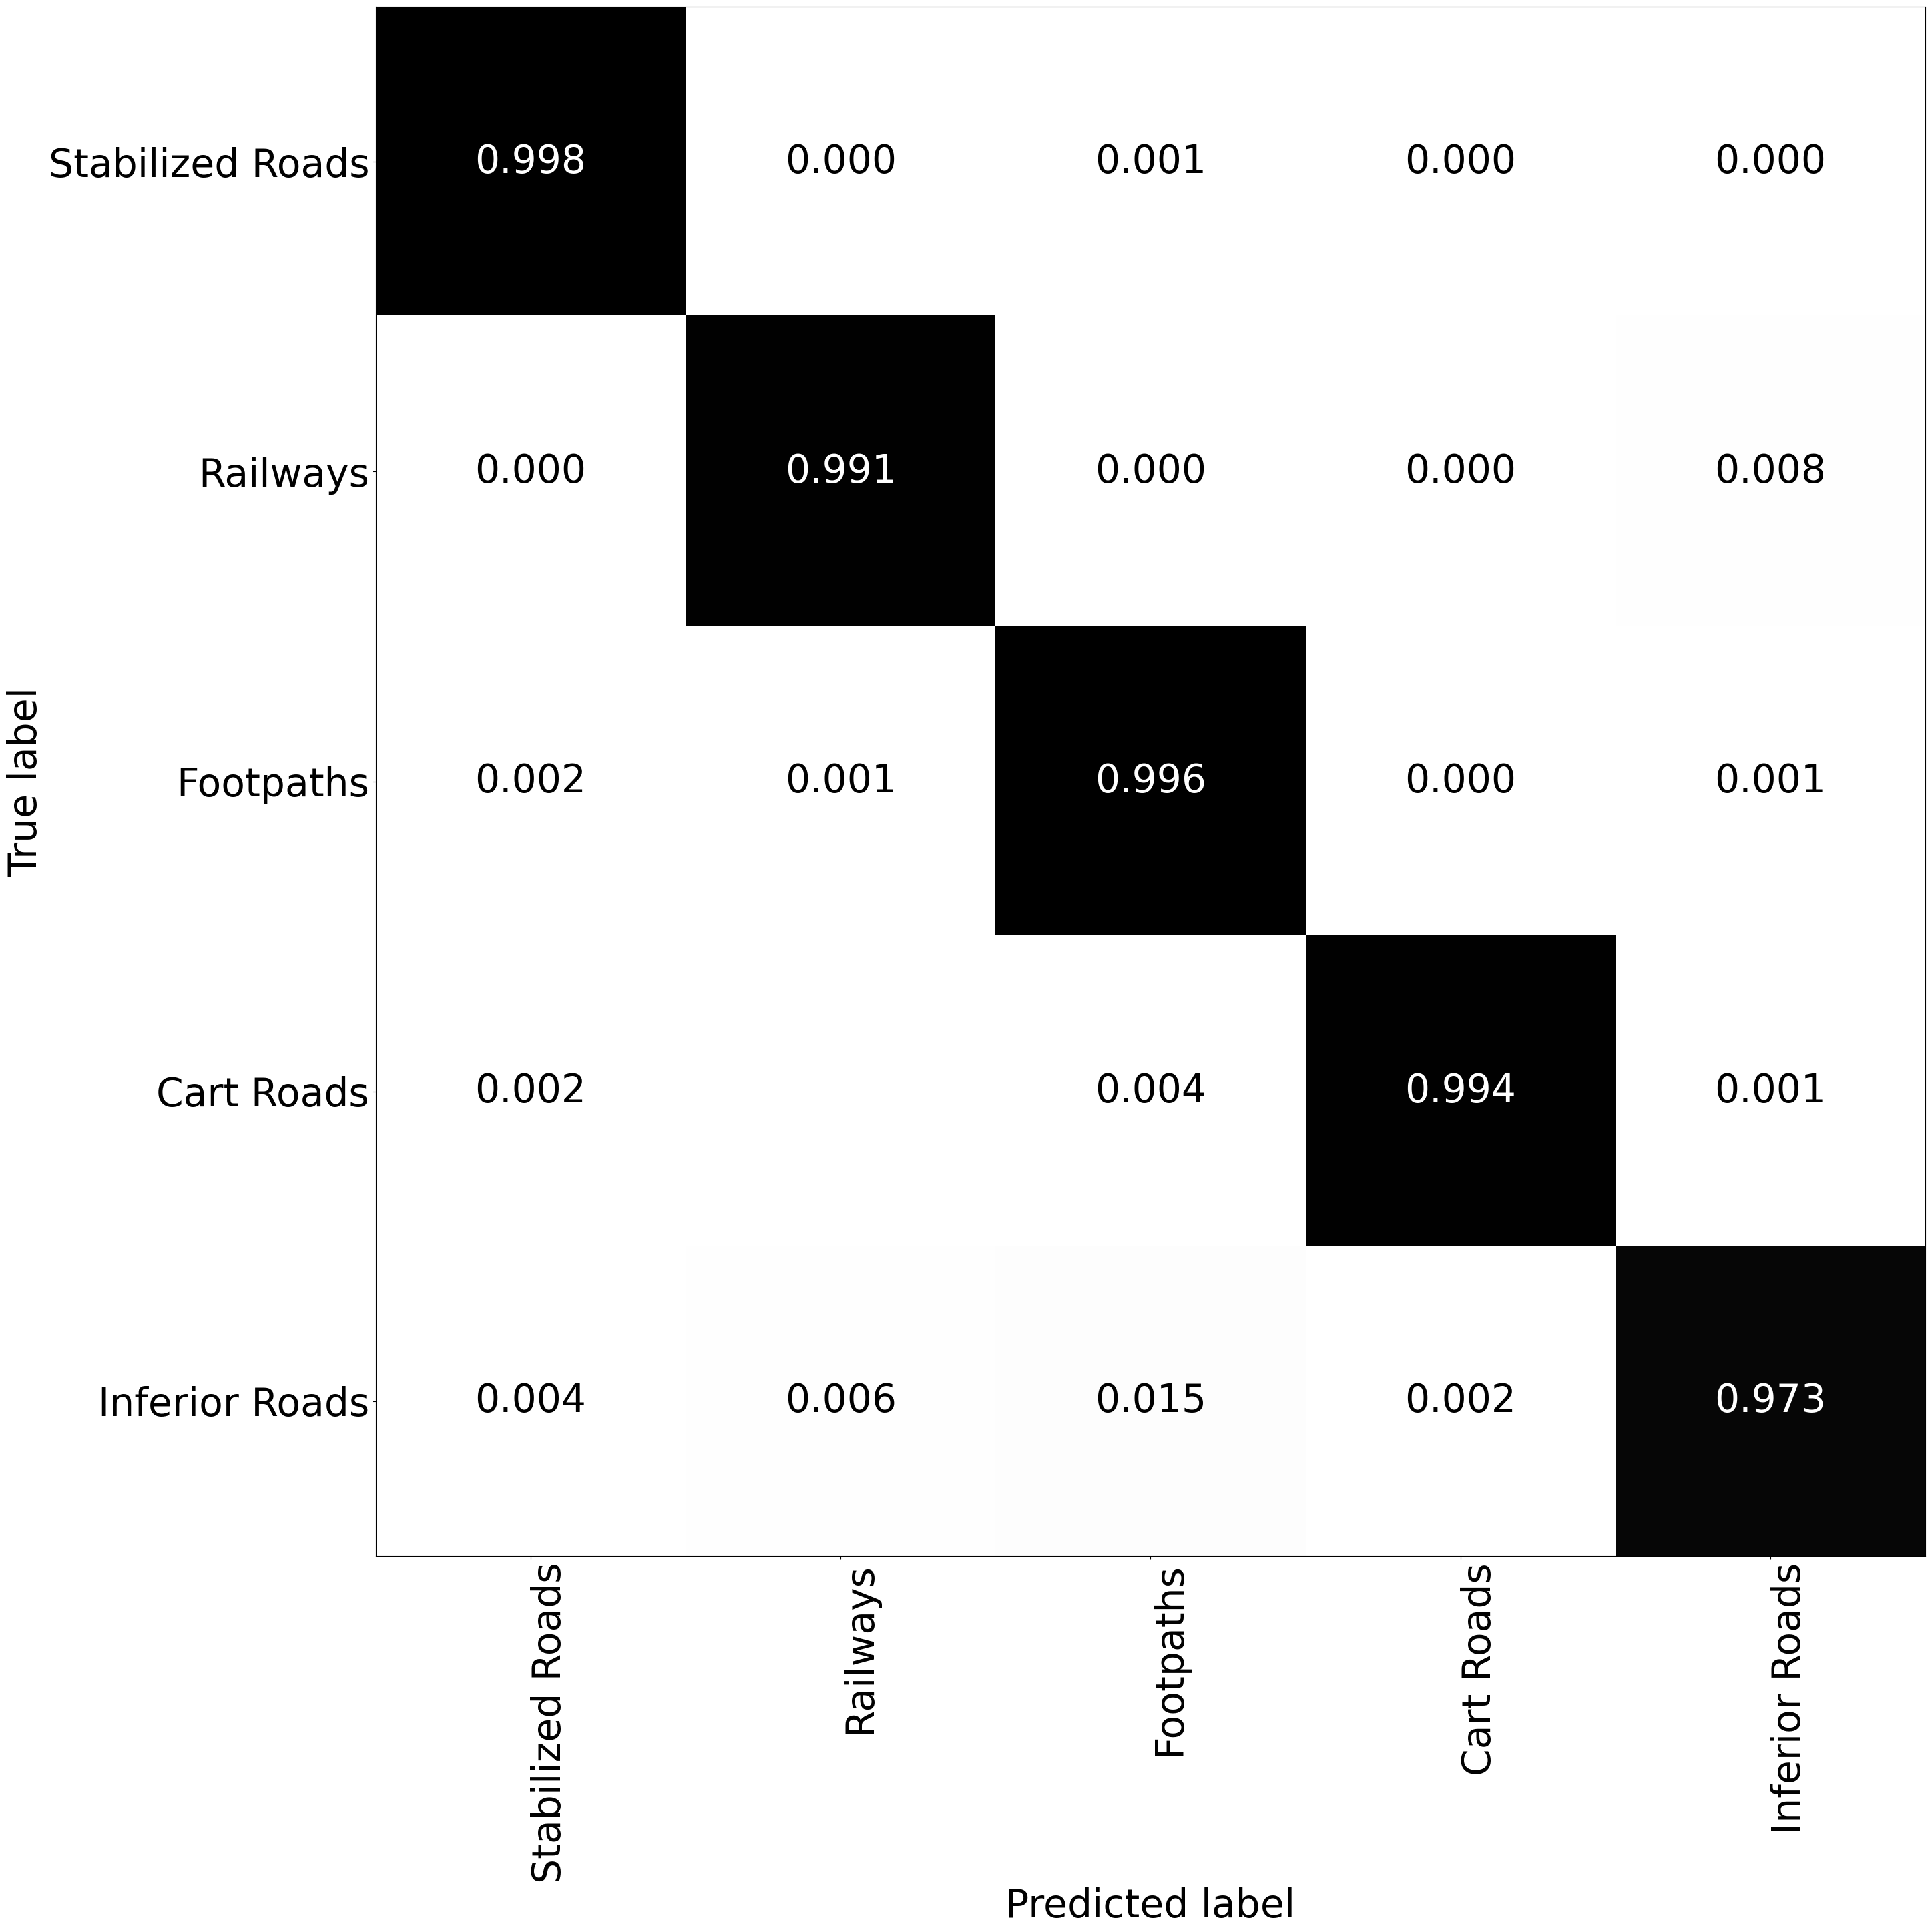

In [23]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [23]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


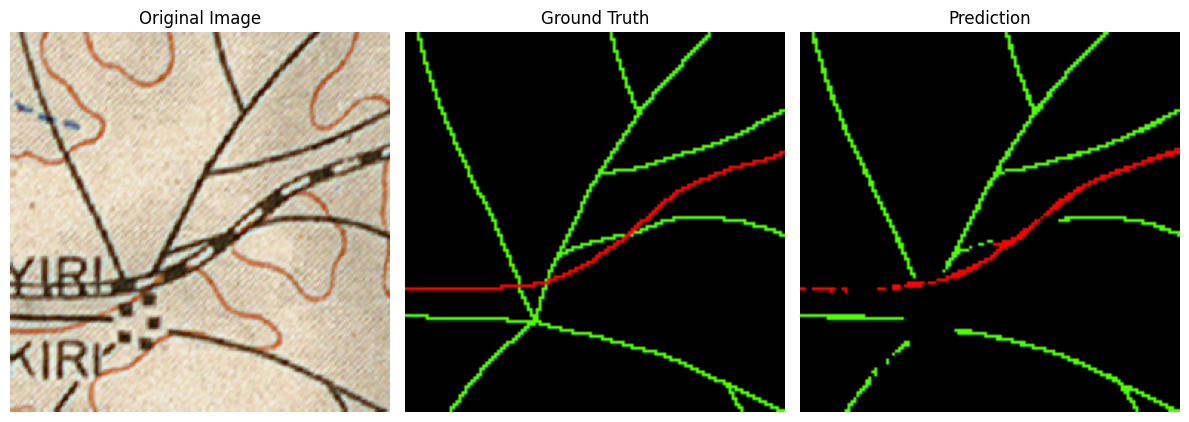

In [34]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
